**Tutorial: https://youtu.be/gQcz_Vc4tso?si=FVhXZGCThHQTx4MJ**

**DISCLAIMER**: Before diving into the specifics of using Monte Carlo simulations for forecasting stock prices, it's crucial to understand that this method should not be directly applied to actual trading without careful consideration. It's essential to thoroughly evaluate any investment strategies through back-testing before applying them in live trading scenarios. Additionally, practicing with paper trading can provide valuable insights into how these strategies and models might perform under real market conditions. Be aware that market conditions can change dramatically, leading to previously successful models underperforming and potentially causing financial losses. This discussion focuses on combining two statistical approaches to create empirical prediction intervals for stock prices. Remember, this is for informational purposes only and should not be considered as financial advice.

### Table of Contents
1. [Importing Dependencies](#Importing-Dependencies)
2. [Importing Stock Data](#Importing-Stock-Data)
    - [a. Global Variables](#Global-Variables)
    - [b. Stock Data Import Function](#Stock-Data-Import-Function)
    - [c. Plot Closing Price](#Plot-Closing-Price)
3. [Functions](#Functions)
    - [a. Daily Log Returns](#Daily-Log-Returns)
    - [b. Plotting Daily Log returns](#Plotting-Daily-Log-Returns)
    - [c. Volatility](#Volatility)
4. [Simulating](#Simulating)
    - [a. Setting Variables](#Setting-Variables)
    - [b. Monte Carlo Simulation](#Monte-Carlo-Simulation)
    - [c. Plotting](#Plotting-Simulation)
5. [Live Testing](#Live-Testing)
    - [a. Results](#Results)
6. [Class](#Monte-Carlo-Simulation-Class)

# Import all Dependencies 
------------------------------------

### If you are in google collab and want to install some of the dependencies use the following command

`pip install numpy pandas pandas-datareader matplotlib seaborn scipy yfinance`


In [58]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import yfinance as yf
from datetime import datetime, timedelta

# Importing Stock Data
-------

## Global Variables
Define your ticker and start date here

In [2]:
ticker = "GOOG"
start_date = '2020-1-1'

## Importing Stock Data
This function takes in a list of tickers and gives out a dataframe of all the stock data.

In the function definition, we write `start = '2010-1-1` as a default value incase the user forgets to enter their own value.

In [3]:
def import_stock_data(ticker, start='2010-1-1'):
    # Define a Dataframe for storing your stock data
    data = pd.DataFrame()
    
    # Using Yahoo Finance to get stock data
    stock = yf.Ticker(ticker)
    data = stock.history(start=start)
        
    return data

## Plot Closing Price

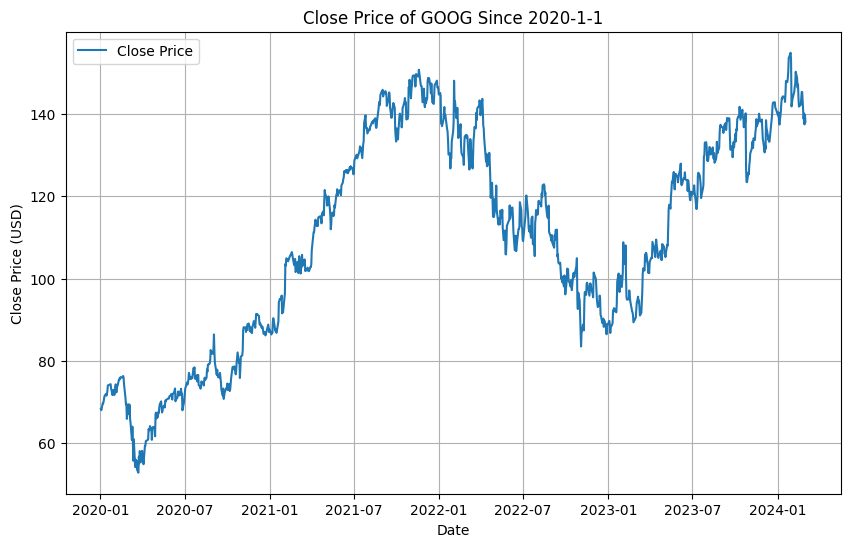

In [4]:
data = import_stock_data(ticker, start = start_date)

# Plot the close price
plt.figure(figsize=(10, 6))
plt.plot(data['Close'], label='Close Price')
plt.title(f'Close Price of {ticker} Since {start_date}')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Functions
-----

## Daily Log Returns

**Why are we using log returns over mean returns?** 
- For small price changes, log returns and simple returns are quite similar. However, for larger price movements, log returns can provide a more accurate and realistic representation of returns, reducing bias in the simulation outcomes.

- The mathematical properties of log returns, such as their additive nature, make them convenient for analytical and computational method.

- Log returns also capture skewness in financial returns better than mean returns along with a variety of factors

In [5]:
def log_returns(stock_data):

    # Assuming you're interested in the 'Close' prices
    log_returns = np.log(1 + stock_data['Close'].pct_change())
    log_returns = log_returns[1:]
    
    return log_returns

## Plotting Log Returns

Date
2024-02-26 00:00:00-05:00   -0.046058
2024-02-27 00:00:00-05:00    0.009683
2024-02-28 00:00:00-05:00   -0.019242
2024-02-29 00:00:00-05:00    0.016955
2024-03-01 00:00:00-05:00   -0.012237
Name: Close, dtype: float64


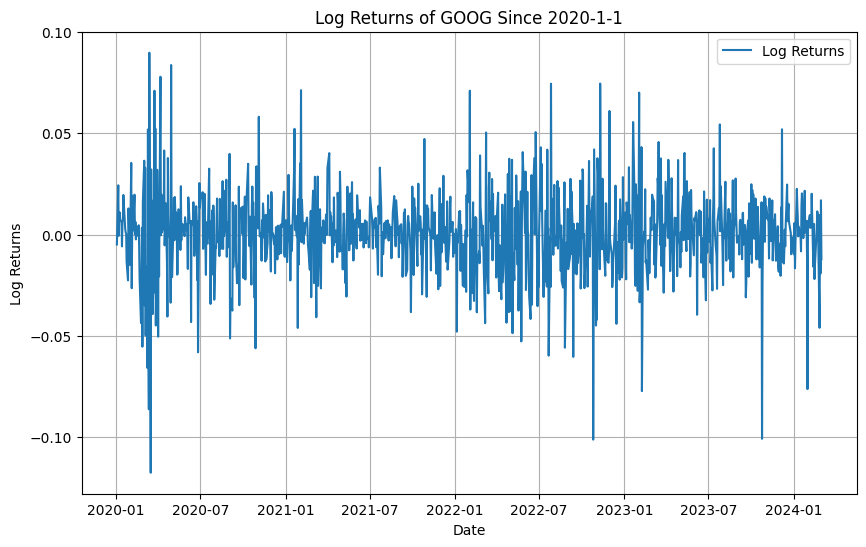

In [6]:
log_return = log_returns(data)

print(log_return.tail())

# Plot the log returns
plt.figure(figsize=(10, 6))
plt.plot(log_return, label='Log Returns')
plt.title(f'Log Returns of {ticker} Since {start_date}')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.grid(True)
plt.show()

## Calcuate the Volatility
Volatility is just the standard deviation of the daily returns in this case

In [7]:
def volatility_calc(lr):
    daily_volatility = np.std(lr)
    return daily_volatility

In [8]:
# Test
log_return = log_returns(data)
print(volatility_calc(log_return))

0.020982289681831287


# Running Simulations
----

## Variables Selection

- More the number of simulations the more accurate your data will be. However, you might be limited by your hardware which is fine for non-professional testing. 
- I randomly chose the number of days to be simulated. You can estimate the price for even tomorrow if you want. I chose 252 since it is the number of trading days in a year. 

In [25]:
num_simulations = 100000
num_days = 100

# Get the closing price for the last day of the stock data
last_price = data['Close'].iloc[-1]

## Simulation Function

In [26]:
def run_monteCarlo(num_simulations, num_days, last_price, log_return):
    # Calculate daily volatility
    daily_vol = volatility_calc(log_return)
    
    # Initialize a list to store all simulation results
    all_simulations = []
    
    for x in range(num_simulations):
        price_series = [last_price]
        
        for y in range(1, num_days):
            price = price_series[-1] * (1 + np.random.normal(0, daily_vol))
            price_series.append(price)
        
        all_simulations.append(price_series)
    
    # Convert the list of simulations into a DataFrame all at once
    simulation_df = pd.DataFrame(all_simulations).transpose()
    
    return simulation_df

In [27]:
# Test
log_return = log_returns(data)
simulation_df = run_monteCarlo(num_simulations , num_days , last_price , log_return)

simulation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,99990,99991,99992,99993,99994,99995,99996,99997,99998,99999
0,138.080002,138.080002,138.080002,138.080002,138.080002,138.080002,138.080002,138.080002,138.080002,138.080002,...,138.080002,138.080002,138.080002,138.080002,138.080002,138.080002,138.080002,138.080002,138.080002,138.080002
1,134.350077,140.051206,136.124420,143.613793,135.571056,137.865131,138.304194,135.685895,135.936861,139.794216,...,138.007614,139.090395,141.497954,138.724535,140.209670,141.578262,138.351763,140.473532,135.711437,138.423018
2,135.935735,140.028635,134.871754,138.788070,135.108688,136.751631,134.888321,136.479054,136.297103,141.274569,...,135.172596,136.204579,138.039595,140.183547,141.086303,142.453440,135.213946,142.819604,133.183719,141.261086
3,137.114450,140.475897,135.735993,141.671750,135.050556,137.885322,137.149793,133.245644,138.231719,139.287503,...,138.065545,134.596528,133.208895,141.347503,146.601395,142.968434,135.656543,150.211053,135.829648,142.724373
4,132.384960,138.208034,137.341541,138.339561,136.375955,140.788399,138.769284,140.113413,136.499731,135.475154,...,134.759130,138.012856,134.010926,139.724135,143.527648,138.991317,131.338423,148.777963,135.674408,139.699465


## Plot Monte Carlo

The part we have all been waiting for :)

Text(0, 0.5, 'Price')

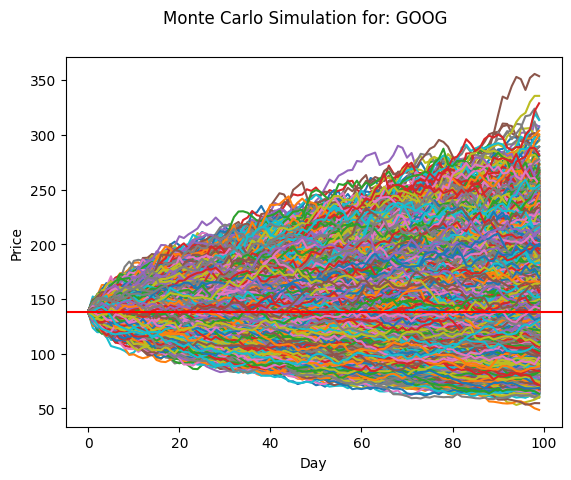

In [28]:
simulation_df.plot(legend=False)
plt.suptitle(f'Monte Carlo Simulation for: {ticker}')
plt.axhline(y = last_price, color = 'r', linestyle= '-')
plt.xlabel('Day')
plt.ylabel('Price')

# Live Testing
----
For the purpose of this video, I ran the simulation for the Google Stock for past 4 years of data (since we are testing days worth of data) and chose to simulate the price for two days later

Today's date was the 27th of Feburary, 2024 and I estimated the price for 29th of Feburary 2024.

Here are my results...

In [23]:
# Extract the prices for the end of the second day (which is the last row in this case)
day_2_prices = simulation_df.iloc[-1]  # Last row since num_days = 2

# Calculate the 95% confidence interval
lower_bound = np.percentile(day_2_prices, 2.5)
upper_bound = np.percentile(day_2_prices, 97.5)

# Calculate the mean (expected) price
mean_price = np.mean(day_2_prices)

# Print the results
print(f"The expected price for 2 days later is: {mean_price}")
print(f"The 95% confidence interval for the price 2 days later is: ({lower_bound}, {upper_bound})")

The expected price for 2 days later is: 138.08993248065642
The 95% confidence interval for the price 2 days later is: (132.38951884548462, 143.7402251754505)


In [24]:
# Calculate the 98% confidence interval
# For a 98% CI, we look for the 1st and 99th percentiles
lower_bound = np.percentile(day_2_prices, 1)
upper_bound = np.percentile(day_2_prices, 99)

# Calculate the mean (expected) price
mean_price = np.mean(day_2_prices)

# Print the results
print(f"The expected price for 2 days later is: {mean_price}")
print(f"The 98% confidence interval for the price 2 days later is: ({lower_bound}, {upper_bound})")

The expected price for 2 days later is: 138.08993248065642
The 98% confidence interval for the price 2 days later is: (131.38673948529916, 144.7955790426222)


## Results

The expected price for 2 days later is: 138.75097515539002

The 95% confidence interval for the price 2 days later is: (130.7107075477952, 146.91774464512181)

The 98% confidence interval for the price 2 days later is: (129.26542805865614, 148.45331385834814)

The actual closing price for Google on the 29th of Feburary was: 

# Monte Carlo Simulation Class

In [59]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import yfinance as yf
from datetime import datetime, timedelta

In [74]:
class MonteCarlo():
    
    def __init__(self , ticker , start_date , end_date , days , sim):
        self.ticker = ticker
        self.start = start_date
        self.end = end_date
        self.noOfSimulations = sim
        self.noOfDays = days
        
        self.import_stock_data()
        self.calc_log_returns()
        self.volatility_calc()
        self.run_monteCarlo()
    
    def import_stock_data(self):
        self.data = pd.DataFrame()
    
        # Using Yahoo Finance to get stock data
        stock = yf.Ticker(ticker)
        self.data = stock.history(start=start)

    def calc_log_returns(self):

        # Assuming you're interested in the 'Close' prices
        self.log_returns = np.log(1 + self.data['Close'].pct_change())
        self.log_returns = self.log_returns[1:]

    def volatility_calc(self):
        self.daily_volatility = np.std(self.log_returns)
    
    def run_monteCarlo(self):
        # Get the last days stock price
        last_price = self.data['Close'].iloc[-1]
        self.last_price = last_price
        
        # Initialize a list to store all simulation results
        all_simulations = []

        for x in range(self.noOfSimulations):
            price_series = [last_price]

            for y in range(1, self.noOfDays):
                price = price_series[-1] * (1 + np.random.normal(0, self.daily_volatility))
                price_series.append(price)

            all_simulations.append(price_series)

        # Convert the list of simulations into a DataFrame all at once
        self.simulation_df = pd.DataFrame(all_simulations).transpose()
                
    def results(self):
        # Extract the prices for the end of the second day (which is the last row in this case)
        prices = self.simulation_df.iloc[-1]  # Last row since num_days = 2

        # Calculate the 95% confidence interval
        lower_bound = np.percentile(prices, 2.5)
        upper_bound = np.percentile(prices, 97.5)

        # Calculate the mean (expected) price
        mean_price = np.mean(prices)

        # Print the results
        print(f"{self.ticker} expected price for {self.noOfDays} days later is: {mean_price}")
        print(f"{self.ticker} 95% confidence interval for the price {self.noOfDays} days later is: ({lower_bound}, {upper_bound})")
        print("\n")
        
    def plot(self):
        self.simulation_df.plot(legend=False)
        plt.suptitle(f'Monte Carlo Simulation for: {self.ticker}')
        plt.axhline(y = self.last_price, color = 'r', linestyle= '-')
        plt.xlabel('Day')
        plt.ylabel('Price')



Now you can run it for multiple stocks at the same time!

In [77]:
# Define your list of tickers
tickers = ["HSCL.NS", "BHEL.NS", "JPASSOCIAT.NS" , "ZOMATO.NS"]

end_date = datetime.now().strftime('%Y-%m-%d')  # Today's date in YYYY-MM-DD format
start_date = (datetime.now() - timedelta(days=2*365)).strftime('%Y-%m-%d')  # Two years before today


# Initialize a dictionary to hold your results
results = {}

# Loop through each ticker and run the simulation
for ticker in tickers:
    simulation = MonteCarlo(ticker, start_date, end_date, 5, 1000)
    simulation.results()
    

AAPL expected price for 5 days later is: 176.00077997915008
AAPL 95% confidence interval for the price 5 days later is: (161.59069392795647, 190.29283864300962)


MSFT expected price for 5 days later is: 422.1154090390462
MSFT 95% confidence interval for the price 5 days later is: (388.1737872552657, 457.46097572058756)


BHEL.NS expected price for 5 days later is: 224.92321696686926
BHEL.NS 95% confidence interval for the price 5 days later is: (198.8988505419947, 252.32263981713356)


JPASSOCIAT.NS expected price for 5 days later is: 17.866060204219348
JPASSOCIAT.NS 95% confidence interval for the price 5 days later is: (15.293559919055925, 20.783827912474475)


ZOMATO.NS expected price for 5 days later is: 165.3729527441035
ZOMATO.NS 95% confidence interval for the price 5 days later is: (143.75714667940488, 189.215006121432)


